# 1 - Imports

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree  
from sklearn import metrics
from sklearn import pipeline
from sklearn.model_selection import GridSearchCV
from feature_engine import discretisation, encoding
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# 2 - Functions

# 3 - Sample

In [60]:
path= 'data/abt_churn.csv'

df= pd.read_csv(path)

X = df.drop(['flagChurn', 'dtRef', 'idUsuario'], axis=1) # excluindo a variavel resposta, campos de data e id
y = df['flagChurn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 0.2 é porque quero 20% dos dados em teste, a maior parte tem que ser em treino


# 4 - Explore

## 4.1 - Missing values

In [61]:
# montando um dataset de treino com a variavel resposta para EDA

df_analise = X_train.copy()
df_analise['target'] = y_train 
pd.set_option('display.max_rows', 500) # para mostrar todas as linhas do sumario

sumario = df_analise.groupby(by='target').agg(['median', 'mean']).T
sumario['diff_abs'] = sumario[0] - sumario[1]
sumario['diff_rel'] = sumario[0] / sumario[1]
sumario.sort_values(by=['diff_rel'], ascending=False) # o objetivo do sumario é ver o quanto a media e mediana descolam pra cada variavel pra churn e nao churn

,target,0,1,diff_abs,diff_rel
qtdeDiasD7,median,1.000000,0.000000,1.000000,inf
qtdeTransacoesD7,median,3.000000,0.000000,3.000000,inf
saldoPontosD7,median,50.000000,0.000000,50.000000,inf
qtdePontosPosD7,median,52.000000,0.000000,52.000000,inf
qtdePontosPosD14,median,105.000000,1.000000,104.000000,105.000000
saldoPontosD14,median,100.000000,1.000000,99.000000,100.000000
qtdePontosNegD7,mean,-63.954998,-3.525180,-60.429818,18.142336
qtdePontosNegD14,mean,-127.437906,-7.889688,-119.548217,16.152464
qtdePontosNegD28,mean,-290.332756,-22.877698,-267.455059,12.690646
qtdeAirflowLover,mean,0.138035,0.015827,0.122208,8.721333


# 5 - Modify

In [62]:
arvore = tree.DecisionTreeClassifier(random_state=42)
arvore.fit(X_train, y_train) # a arvore sempre é fitada com dados de treino tanto do dataset sem a variavel resposta e a variavel resposta

#plt.figure(dpi=400)
# tree.plot_tree(arvore, feature_names=X_train.columns,
  #             filled=True,
   #            class_names= [str(i) for i in arvore.classes_] )
# pra plotar a arvore com as variaveis mais importantes pra dividir o dataset, mas como ela fica muito grande, vou criar uma serie com a lista das variaveis por ordem de importancia pra ficar mais facil


feature_importances = (pd.Series(arvore.feature_importances_, index=X_train.columns)
                      .sort_values(ascending=False)
                      .reset_index()
                      .rename(columns={'index': 'feature', 0: 'importance'}))

feature_importances['acumulado'] = feature_importances['importance'].cumsum()
best_features = feature_importances[feature_importances['acumulado'] < 0.96]['feature'].tolist()

In [63]:
tree_discretization = discretisation.DecisionTreeDiscretiser(random_state=42, variables=best_features, regression=False, bin_output='bin_number', cv=3)

tree_discretization.fit(X_train[best_features], y_train)
X_train_transform = tree_discretization.transform(X_train[best_features])

# fazendo o one hot encoding nas variavies binadas pela decision tree
one_hot = encoding.OneHotEncoder(variables=best_features, ignore_format=True)
one_hot.fit(X_train_transform, y_train)

X_train_transform = one_hot.transform(X_train_transform)




# 6 - Modeling

In [68]:

# Decision tree
decision_tree = tree.DecisionTreeClassifier(random_state=42, min_samples_leaf=20)
decision_tree.fit(X_train_transform, y_train)

params_decision_tree = {
'min_samples_leaf': [15,20,25,30,50],
'criterion': ['gini', 'entropy', 'log_loss']

}

grid_decision_tree = GridSearchCV(decision_tree, params_decision_tree, cv=3, scoring='roc_auc', verbose=4)


model_pipeline_decision_tree = pipeline.Pipeline(
    steps=[
        ('Discretizar', tree_discretization),
        ('One Hot', one_hot),
        ('Grid', grid_decision_tree)
    ]
)

model_pipeline_decision_tree.fit(X_train, y_train)


# Log loss
logloss = LogisticRegression(random_state=42)
logloss.fit(X_train_transform, y_train)


model_pipeline_logloss = pipeline.Pipeline(
    steps=[
        ('Discretizar', tree_discretization),
        ('One Hot', one_hot),
        ('Model', logloss)
    ]
)

model_pipeline_logloss.fit(X_train, y_train)

# Random forest
random_forest = RandomForestClassifier(
    n_estimators=100,      
    max_depth=10,          
    min_samples_split=2,   
    min_samples_leaf=1,    
    random_state=42,
    n_jobs=-1            
)

random_forest.fit(X_train_transform, y_train)

params_random_forest = {
'n_estimators': [100,200,250,300,500],
'max_depth': [10,20],
'min_samples_split': [2,4,6],   
'min_samples_leaf': [1,2,3]

}

grid_random_forest = GridSearchCV(random_forest, params_random_forest, cv=3, scoring='roc_auc', verbose=4)


model_pipeline_random_forest = pipeline.Pipeline(
    steps=[
        ('Discretizar', tree_discretization),
        ('One Hot', one_hot),
        ('Grid', grid_random_forest)
    ]
)

model_pipeline_random_forest.fit(X_train, y_train)



Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END criterion=gini, min_samples_leaf=15;, score=0.785 total time=   0.0s
[CV 2/3] END criterion=gini, min_samples_leaf=15;, score=0.775 total time=   0.0s
[CV 3/3] END criterion=gini, min_samples_leaf=15;, score=0.789 total time=   0.0s
[CV 1/3] END criterion=gini, min_samples_leaf=20;, score=0.797 total time=   0.0s
[CV 2/3] END criterion=gini, min_samples_leaf=20;, score=0.776 total time=   0.0s
[CV 3/3] END criterion=gini, min_samples_leaf=20;, score=0.804 total time=   0.0s
[CV 1/3] END criterion=gini, min_samples_leaf=25;, score=0.798 total time=   0.0s
[CV 2/3] END criterion=gini, min_samples_leaf=25;, score=0.783 total time=   0.0s
[CV 3/3] END criterion=gini, min_samples_leaf=25;, score=0.808 total time=   0.0s
[CV 1/3] END criterion=gini, min_samples_leaf=30;, score=0.796 total time=   0.0s
[CV 2/3] END criterion=gini, min_samples_leaf=30;, score=0.789 total time=   0.0s
[CV 3/3] END criterion=gini, min_samp

c:\Users\User\Documents\repos\curso_ml_teo\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.817 total time=   0.1s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.809 total time=   0.1s
[CV 3/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.818 total time=   0.2s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.818 total time=   0.4s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.811 total time=   0.4s
[CV 3/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.820 total time=   0.4s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.818 total time=   0.5s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.811 total time=  

,steps,"[('Discretizar', ...), ('One Hot', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,variables,"['qtdeDiasD14', 'propAvgQtdeDias', ...]"
,bin_output,'bin_number'
,precision,None
,cv,3
,scoring,'neg_mean_squared_error'
,param_grid,None
,regression,False


# 7 - Assess

In [69]:
# decision tree 
y_train_predict = model_pipeline_decision_tree.predict(X_train)
y_train_proba = model_pipeline_decision_tree.predict_proba(X_train)[:,1]

acc_train_decision_tree = metrics.accuracy_score(y_train, y_train_predict)
auc_train_decision_tree= metrics.roc_auc_score(y_train, y_train_proba)
roc_train_decision_tree = metrics.roc_curve(y_train, y_train_proba)


# logloss 
y_train_predict = model_pipeline_logloss.predict(X_train)
y_train_proba = model_pipeline_logloss.predict_proba(X_train)[:,1]

acc_train_logloss = metrics.accuracy_score(y_train, y_train_predict)
auc_train_logloss = metrics.roc_auc_score(y_train, y_train_proba)
roc_train_logloss = metrics.roc_curve(y_train, y_train_proba)


# random forest 
y_train_predict = model_pipeline_random_forest.predict(X_train)
y_train_proba = model_pipeline_random_forest.predict_proba(X_train)[:,1]

acc_train_random_forest = metrics.accuracy_score(y_train, y_train_predict)
auc_train_random_forest = metrics.roc_auc_score(y_train, y_train_proba)
roc_train_random_forest = metrics.roc_curve(y_train, y_train_proba)


print(f'Acuracia treino decision tree:', acc_train_decision_tree)
print(f'AUC treino treino decision tree:', auc_train_decision_tree)


print(f'Acuracia treino log loss:', acc_train_logloss)
print(f'AUC treino log loss:', auc_train_logloss)


print(f'Acuracia treino random forest:', acc_train_random_forest)
print(f'AUC treino random forest:', auc_train_random_forest)



Acuracia treino decision tree: 0.7556869881710646
AUC treino treino decision tree: 0.8381971532250616
Acuracia treino log loss: 0.7343039126478617
AUC treino log loss: 0.8122436019163899
Acuracia treino random forest: 0.7907188353048226
AUC treino random forest: 0.8826139607569679


In [71]:

# decision tree
y_test_predict_decision_tree = model_pipeline_decision_tree.predict(X_test)
y_test_proba_decision_tree = model_pipeline_decision_tree.predict_proba(X_test)[:,1]

acc_test_decision_tree = metrics.accuracy_score(y_test, y_test_predict_decision_tree)
auc_test_decision_tree = metrics.roc_auc_score(y_test, y_test_proba_decision_tree)
roc_test_decision_tree = metrics.roc_curve(y_test, y_test_proba_decision_tree)

print('Acuracia treino decision tree:', acc_test_decision_tree)
print('AUC treino decision tree:', auc_test_decision_tree)


# log loss
y_test_predict_logloss = model_pipeline_logloss.predict(X_test)
y_test_proba_logloss = model_pipeline_logloss.predict_proba(X_test)[:,1]

acc_test_logloss = metrics.accuracy_score(y_test, y_test_predict_logloss)
auc_test_logloss = metrics.roc_auc_score(y_test, y_test_proba_logloss)
roc_test_logloss = metrics.roc_curve(y_test, y_test_proba_logloss)

print('Acuracia treino log loss:', acc_test_logloss)
print('AUC treino log loss:', auc_test_logloss)


# random forest
y_test_predict_random_forest = model_pipeline_random_forest.predict(X_test)
y_test_proba_random_forest = model_pipeline_random_forest.predict_proba(X_test)[:,1]

acc_test_random_forest = metrics.accuracy_score(y_test, y_test_predict_random_forest)
auc_test_random_forest = metrics.roc_auc_score(y_test, y_test_proba_random_forest)
roc_test_random_forest = metrics.roc_curve(y_test, y_test_proba_random_forest)

print('Acuracia treino random forest:', acc_test_random_forest)
print('AUC treino random forest:', auc_test_random_forest)


Acuracia treino decision tree: 0.7418181818181818
AUC treino decision tree: 0.8242188410575076
Acuracia treino log loss: 0.7481818181818182
AUC treino log loss: 0.8243520451828393
Acuracia treino random forest: 0.7363636363636363
AUC treino random forest: 0.8307924646426301


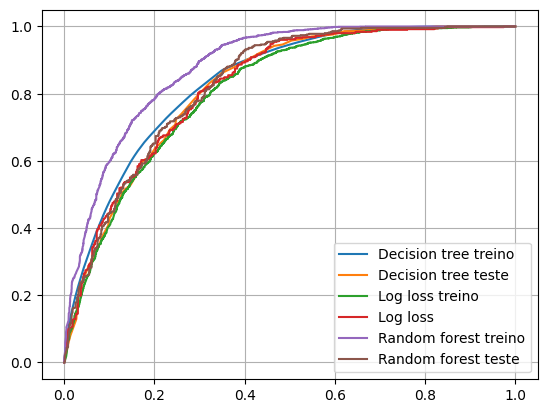

In [72]:
# decision tree
plt.plot(roc_train_decision_tree[0], roc_train_decision_tree[1], label='Decision tree treino')
plt.plot(roc_test_decision_tree[0], roc_test_decision_tree[1], label='Decision tree teste' )
plt.grid(True)
plt.legend()


# log loss
plt.plot(roc_train_logloss[0], roc_train_logloss[1], label='Log loss treino')
plt.plot(roc_test_logloss[0], roc_test_logloss[1], label='Log loss')
plt.grid(True)
plt.legend()

# random forest
plt.plot(roc_train_random_forest[0], roc_train_random_forest[1], label='Random forest treino')
plt.plot(roc_test_random_forest[0], roc_test_random_forest[1], label='Random forest teste')
plt.grid(True)
plt.legend()

In [ ]:
# REPASSAR AULA 23 DE HIPERPARAMETROS 18M DO VIDEO e o grid dentro do pipeline nos 39m do video
# ENTENDER PORQUE TA DESCOLANDO O MODELO
# VER MLFLOW DEPOIS
# VOLTAR E REVISAR TUDO
# NOVAS PREDIÇOES - SERIALIZAÇAO 17M DO VIDEO COM PANDAS E PKL E 25M EM DIANTE PELO MLFLOW QUE É O MAIS INDICADO (ver playlist mlflow)
    # DEPLOY BATCH
    # DEPLOY COM APP (STREAMLIT,ETC)
    # API